In [1]:
# let's do all the necessary imports first

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Defining my train and test directories
train_dir = 'C:/Users/kaczm/OneDrive/Dokumenty/archive (11)/train'
test_dir = 'C:/Users/kaczm/OneDrive/Dokumenty/archive (11)/test'

In [3]:
# transoforming pixel values from 1 to 255 to <0,1> - this is because I don't want the NN to process big numbers as I read it can make the 
# algorithm slow

# also I want to have a validation set to see when the NN starts overfitting so let's create it 

datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)


# defining train and test generators

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # All images will be resized to 48x48
    batch_size=200,
    class_mode='categorical',  
    color_mode='grayscale', # Since we have grayscale images
    subset='training',
    seed = 42)  

validation_generator = datagen_train.flow_from_directory(
    train_dir,  # same directory as training data
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', # set as validation data
    seed = 42)  


datagen_test = ImageDataGenerator(rescale=1./255)  # we don't need validation split for the test data

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(48, 48),  
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    seed = 42)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


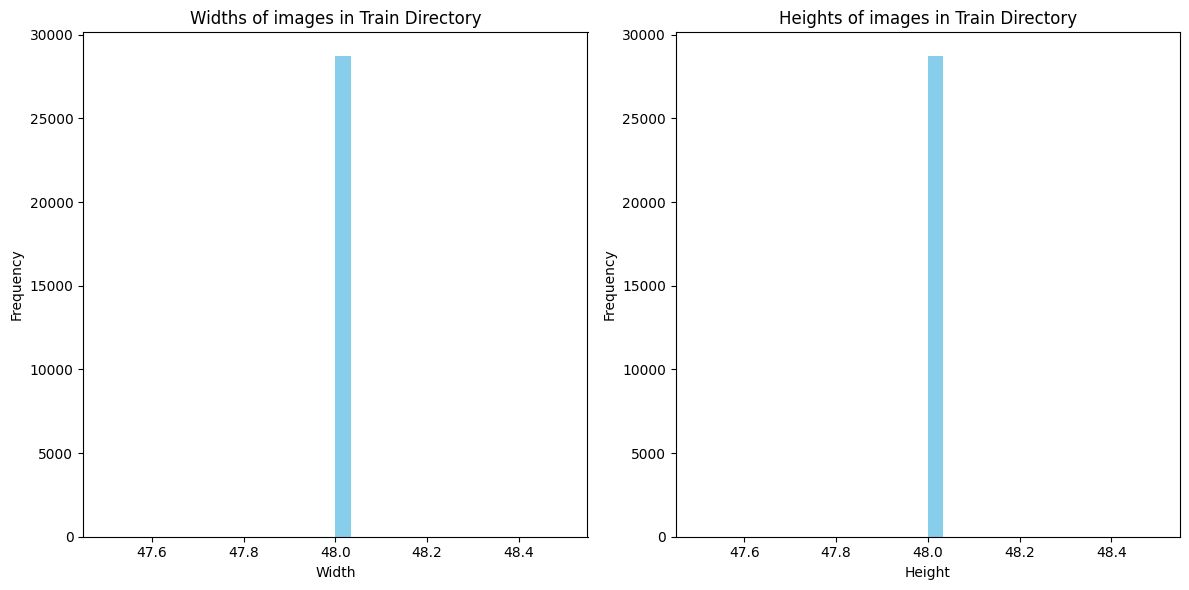

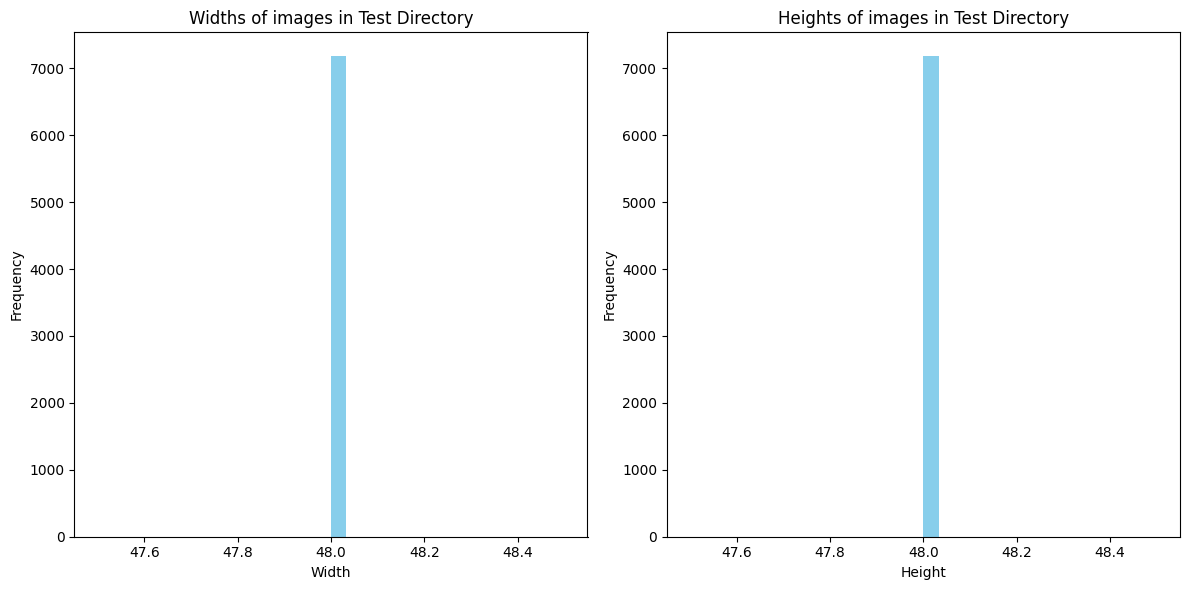

In [100]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def get_image_sizes(directory):
    sizes = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
                img = Image.open(os.path.join(dirpath, filename))
                sizes.append(img.size)  # (width, height)
    return sizes

def plot_histograms(sizes, directory):
    widths, heights = zip(*sizes)  # Separate widths and heights

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='skyblue')
    plt.title(f"Widths of images in {directory}")
    plt.xlabel("Width")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='skyblue')
    plt.title(f"Heights of images in {directory}")
    plt.xlabel("Height")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Get sizes
train_sizes = get_image_sizes(train_dir)
test_sizes = get_image_sizes(test_dir)

# Plot histograms
plot_histograms(train_sizes, "Train Directory")
plot_histograms(test_sizes, "Test Directory")

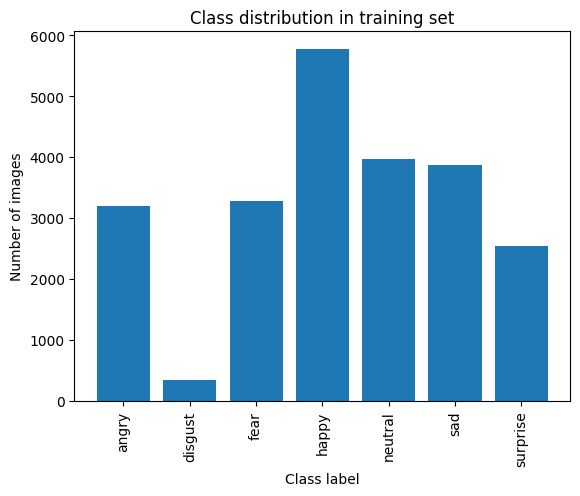

In [45]:
# let's see class distribution

from collections import Counter

# Get class labels for all images in the generator
class_labels = train_generator.classes

# Count the number of occurrences of each class label
class_counts = Counter(class_labels)

# Separate the class labels and their counts into two lists
labels, counts = zip(*class_counts.items())

# Get a reverse mapping from class index to class name
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Replace class indices with class names
class_names = [index_to_class[label] for label in labels]

# Plot the distribution
plt.bar(class_names, counts)
plt.xlabel('Class label')
plt.ylabel('Number of images')
plt.title('Class distribution in training set')
plt.xticks(rotation=90)  # Rotate class names for better display
plt.show()

# ok, we can clearly see an issue - the disgust class is heavily underrepresented

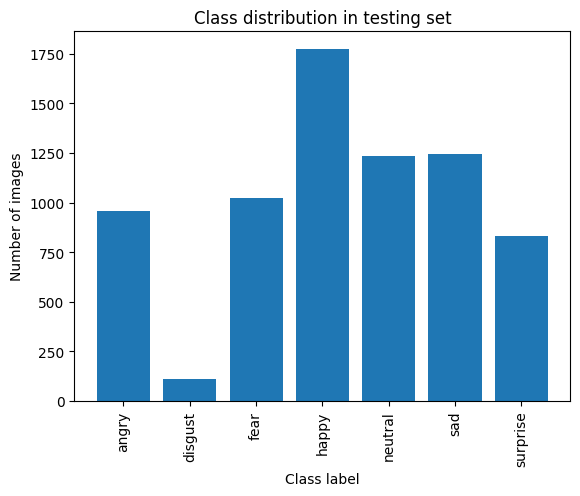

In [10]:
# let's do the same for test set to see if it differs 

from collections import Counter

# Get class labels for all images in the generator
class_labels = test_generator.classes

# Count the number of occurrences of each class label
class_counts = Counter(class_labels)

# Separate the class labels and their counts into two lists
labels, counts = zip(*class_counts.items())

# Get a reverse mapping from class index to class name
index_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Replace class indices with class names
class_names = [index_to_class[label] for label in labels]

# Plot the distribution
plt.bar(class_names, counts)
plt.xlabel('Class label')
plt.ylabel('Number of images')
plt.title('Class distribution in testing set')
plt.xticks(rotation=90)  # Rotate class names for better display
plt.show()


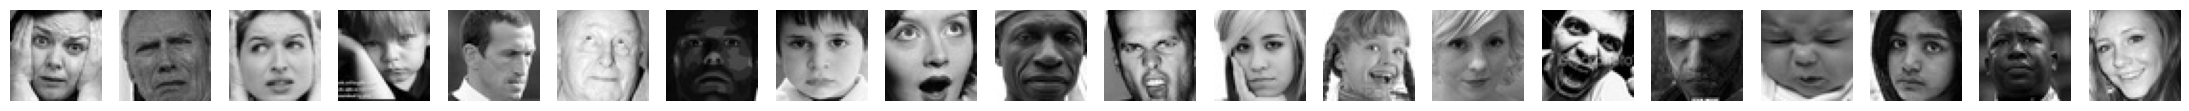

In [21]:
# let's plot every 10th image to see what they look like

# Get a batch of images
images, labels = next(train_generator)

# Select every 10th image from this batch
selected_images = images[::10]

# Plot images
fig, axes = plt.subplots(1, len(selected_images), figsize=(28, 28))

for img, ax in zip(selected_images, axes):
    ax.imshow(img.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
    ax.axis('off')

plt.show()

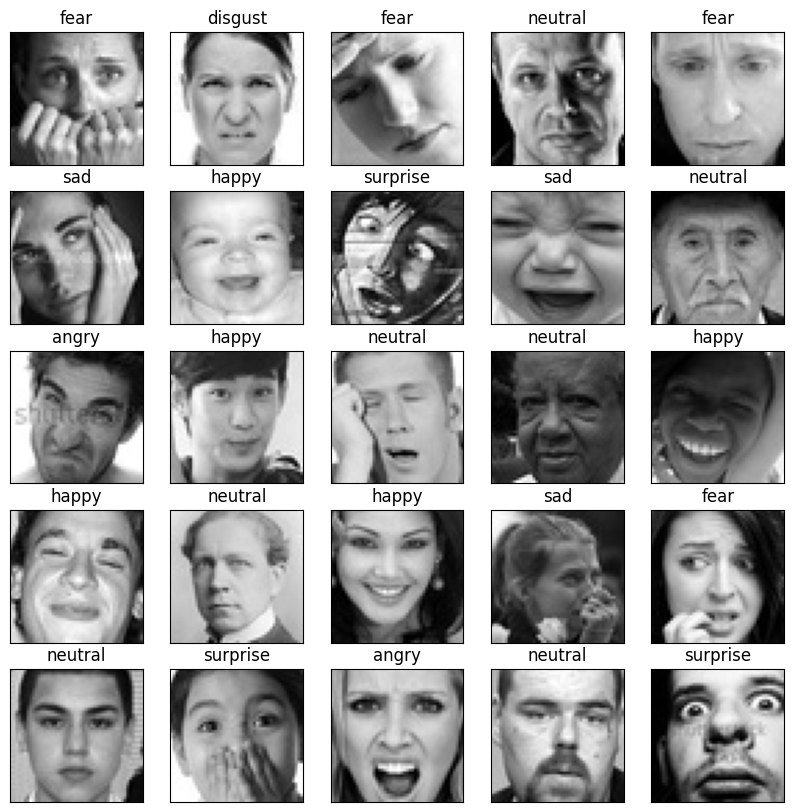

In [99]:
# let's adjust this code so that each image will have a label on the plot

class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

# Get a batch of images and their labels
images, labels = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
    
    # Get the class name for the label
    class_name = class_names[np.argmax(labels[i])]
    
    # Display the class name as the title of the subplot
    plt.title(class_name)
    
plt.show()



In [27]:
# now let's build a simple FNN classifier serving us a reference model
# we will start with a 300 input layers, ofc 7 neurons as output, 3 dense layers in between 

model = keras.models.Sequential([keras.layers.Flatten(input_shape = [48, 48]),
keras.layers.Dense(300, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(7, activation = 'softmax' )])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_5 (Dense)             (None, 300)               691500    
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 7)                 707       
                                                                 
Total params: 742,507
Trainable params: 742,507
Non-tr

In [29]:
# let's compile the model

model.compile(loss = 'categorical_crossentropy',
optimizer = 'sgd', # The optimizer we are going to use to optimise the model against the loss function is stochastic gradient descent and this will ensure the model converges on an optimum solution
metrics = ['accuracy'])

In [30]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator 
)

Epoch 1/10
115/115 [==============================] - 26s 222ms/step - loss: 1.8207 - accuracy: 0.2420 - val_loss: 1.7929 - val_accuracy: 0.2623
Epoch 2/10
115/115 [==============================] - 12s 101ms/step - loss: 1.7789 - accuracy: 0.2702 - val_loss: 1.7705 - val_accuracy: 0.2857
Epoch 3/10
115/115 [==============================] - 12s 109ms/step - loss: 1.7568 - accuracy: 0.2889 - val_loss: 1.7481 - val_accuracy: 0.3003
Epoch 4/10
115/115 [==============================] - 13s 111ms/step - loss: 1.7361 - accuracy: 0.3085 - val_loss: 1.7655 - val_accuracy: 0.2761
Epoch 5/10
115/115 [==============================] - 12s 108ms/step - loss: 1.7262 - accuracy: 0.3142 - val_loss: 1.7166 - val_accuracy: 0.3193
Epoch 6/10
115/115 [==============================] - 13s 109ms/step - loss: 1.7091 - accuracy: 0.3226 - val_loss: 1.7038 - val_accuracy: 0.3337
Epoch 7/10
115/115 [==============================] - 14s 120ms/step - loss: 1.6993 - accuracy: 0.3313 - val_loss: 1.7246 - val_ac

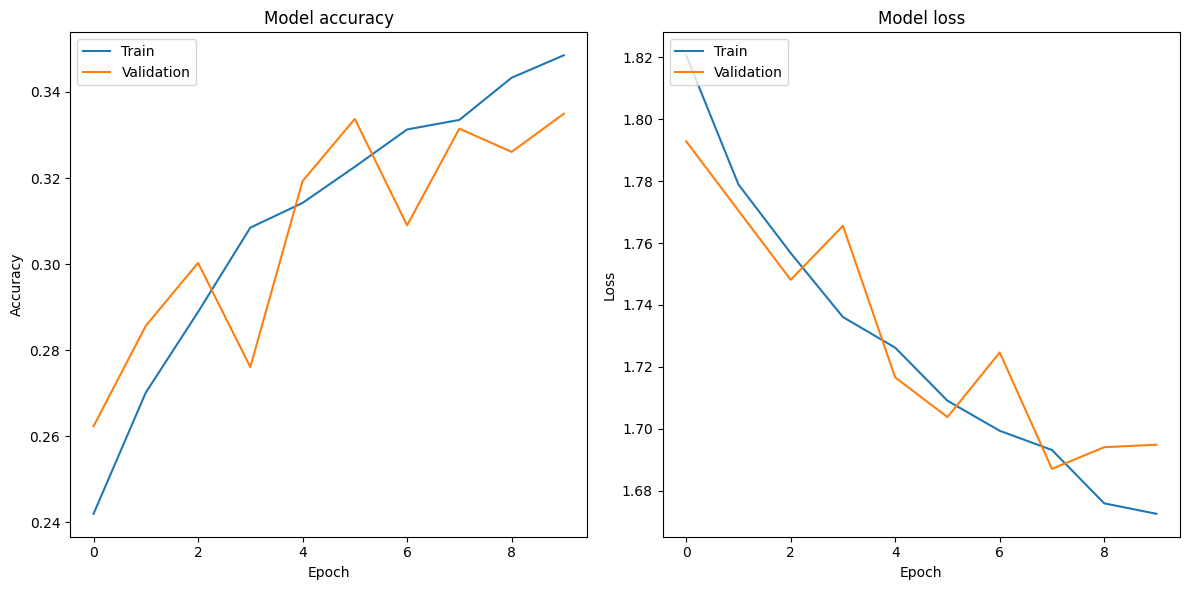

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
# let's evaluate the model

test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

36/36 [==============================] - 9s 252ms/step - loss: 1.6790 - accuracy: 0.3533
Test loss: 1.68
Test accuracy: 0.35


In [33]:
# those values are underwhelming - first of all, we can see that maybe a few more epochs could be used, howeber the loss started rising at the end
# so I'm not sure about that
# also, let's use some regularization techniques to improve the model

datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # reserve some images for validation
    rotation_range=20,    # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of their width
    height_shift_range=0.2, # shift images vertically by up to 20% of their height
    zoom_range=0.2,       # zoom in on images by up to 20%
    horizontal_flip=True, # flip images horizontally
)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',  
    color_mode='grayscale',
    subset='training',
    seed = 42)  

validation_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', 
    seed = 42) 

# btw we ofc don't want to apply those techniques to our test set

# i am also gonna add one more layer to the network


model = keras.models.Sequential([keras.layers.Flatten(input_shape = [48, 48]),
keras.layers.Dense(300, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(100, activation = 'relu' ),
keras.layers.Dense(7, activation = 'softmax' )])


model.compile(loss = 'categorical_crossentropy',
optimizer = 'sgd', # The optimizer we are going to use to optimise the model against the loss function is stochastic gradient descent and this will ensure the model converges on an optimum solution
metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 13,
    validation_data = validation_generator 
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/13
115/115 [==============================] - 32s 275ms/step - loss: 1.8469 - accuracy: 0.2466 - val_loss: 1.8168 - val_accuracy: 0.2517
Epoch 2/13
115/115 [==============================] - 37s 326ms/step - loss: 1.8146 - accuracy: 0.2512 - val_loss: 1.8115 - val_accuracy: 0.2517
Epoch 3/13
115/115 [==============================] - 35s 306ms/step - loss: 1.8103 - accuracy: 0.2515 - val_loss: 1.8088 - val_accuracy: 0.2513
Epoch 4/13
115/115 [==============================] - 32s 278ms/step - loss: 1.8070 - accuracy: 0.2524 - val_loss: 1.8035 - val_accuracy: 0.2512
Epoch 5/13
115/115 [==============================] - 31s 273ms/step - loss: 1.8041 - accuracy: 0.2534 - val_loss: 1.8000 - val_accuracy: 0.2554
Epoch 6/13
115/115 [==============================] - 28s 244ms/step - loss: 1.8016 - accuracy: 0.2529 - val_loss: 1.7993 - val_accuracy: 0.2538
Epoch 7/13
115/115 [=========================

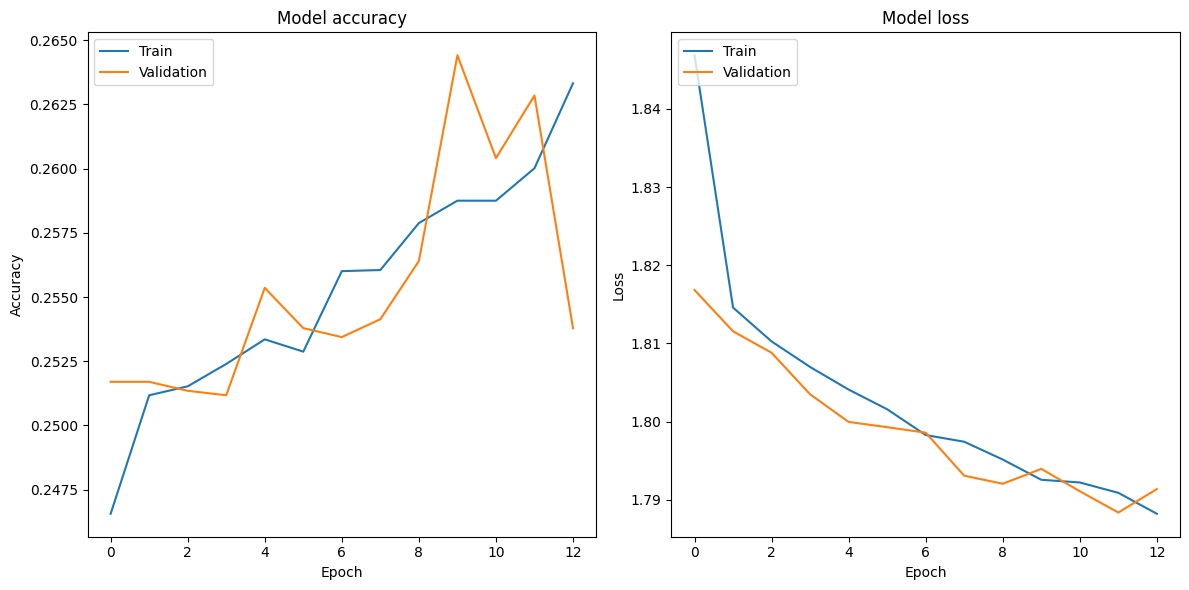

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

In [35]:
# the model slowed down and it didn't achieve better accuracy; let's instead remove 2 layers and maybe add some regularization 
# using L2 norm

from tensorflow.keras import regularizers

datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # reserve some images for validation
    rotation_range=20,    # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of their width
    height_shift_range=0.2, # shift images vertically by up to 20% of their height
    zoom_range=0.2,       # zoom in on images by up to 20%
    horizontal_flip=True, # flip images horizontally
)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',  
    color_mode='grayscale',
    subset='training',
    seed = 42)  

validation_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', 
    seed = 42) 

# btw we ofc don't want to apply those techniques to our test set

# i am also gonna add one more layer to the network


model = keras.models.Sequential([keras.layers.Flatten(input_shape = [48, 48]),
keras.layers.Dense(300, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
keras.layers.Dense(7, activation = 'softmax' )])


model.compile(loss = 'categorical_crossentropy',
optimizer = 'sgd', # The optimizer we are going to use to optimise the model against the loss function is stochastic gradient descent and this will ensure the model converges on an optimum solution
metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 11,
    validation_data = validation_generator 
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/11
115/115 [==============================] - 25s 216ms/step - loss: 2.7146 - accuracy: 0.2513 - val_loss: 2.6870 - val_accuracy: 0.2503
Epoch 2/11
115/115 [==============================] - 25s 214ms/step - loss: 2.6830 - accuracy: 0.2517 - val_loss: 2.6755 - val_accuracy: 0.2520
Epoch 3/11
115/115 [==============================] - 29s 251ms/step - loss: 2.6752 - accuracy: 0.2545 - val_loss: 2.6710 - val_accuracy: 0.2515
Epoch 4/11
115/115 [==============================] - 28s 242ms/step - loss: 2.6671 - accuracy: 0.2559 - val_loss: 2.6626 - val_accuracy: 0.2597
Epoch 5/11
115/115 [==============================] - 26s 228ms/step - loss: 2.6606 - accuracy: 0.2561 - val_loss: 2.6566 - val_accuracy: 0.2634
Epoch 6/11
115/115 [==============================] - 30s 263ms/step - loss: 2.6552 - accuracy: 0.2571 - val_loss: 2.6490 - val_accuracy: 0.2571
Epoch 7/11
115/115 [=========================

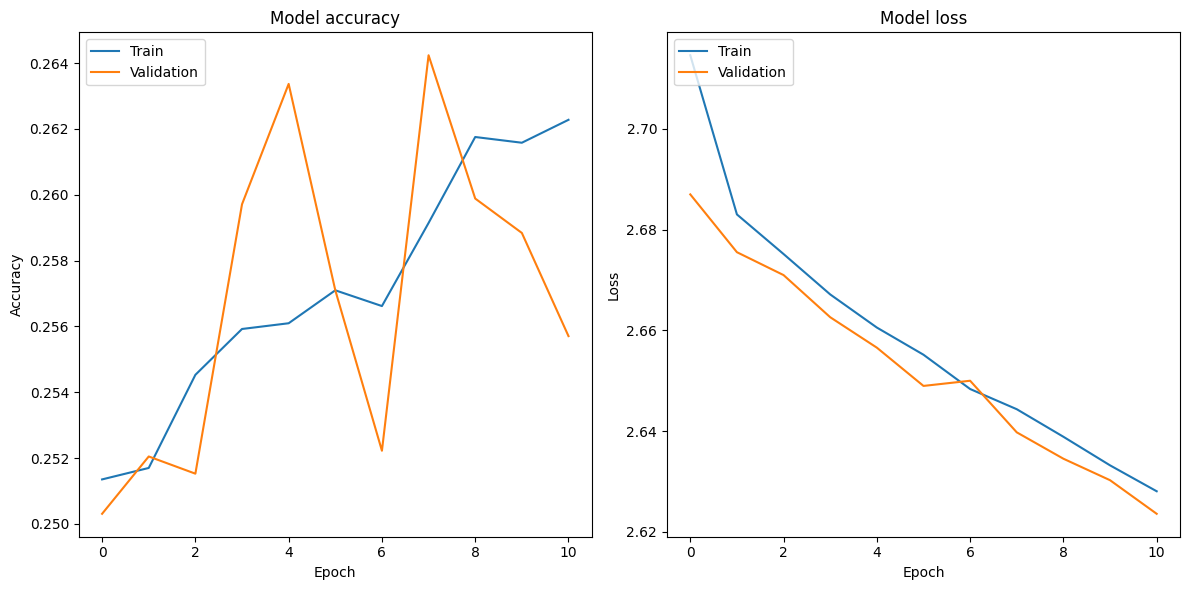

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# after all the first model with no augmentation techniques seems to work best

36/36 [==============================] - 3s 91ms/step - loss: 2.6115 - accuracy: 0.2640
Test loss: 2.61
Test accuracy: 0.26


In [38]:
# one last try with adam optimizer instead of sgd

datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)


# defining train and test generators

train_generator = datagen_train .flow_from_directory(
    train_dir,
    target_size=(48, 48),  # All images will be resized to 48x48
    batch_size=200,
    class_mode='categorical',  
    color_mode='grayscale', # Since we have grayscale images
    subset='training',
    seed = 42)  

validation_generator = datagen_train.flow_from_directory(
    train_dir,  # same directory as training data
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', # set as validation data
    seed = 42)  


datagen_test = ImageDataGenerator(rescale=1./255)  # we don't need validation split for the test data

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(48, 48),  
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    seed = 42)

model = keras.models.Sequential([keras.layers.Flatten(input_shape = [48, 48]),
keras.layers.Dense(300, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(7, activation = 'softmax' )])


model.compile(loss = 'categorical_crossentropy',
optimizer = 'adam', # The optimizer we are going to use to optimise the model against the loss function is stochastic gradient descent and this will ensure the model converges on an optimum solution
metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator 
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/10
115/115 [==============================] - 16s 129ms/step - loss: 1.8690 - accuracy: 0.2649 - val_loss: 1.8014 - val_accuracy: 0.3121
Epoch 2/10
115/115 [==============================] - 17s 145ms/step - loss: 1.7898 - accuracy: 0.3083 - val_loss: 1.7645 - val_accuracy: 0.3337
Epoch 3/10
115/115 [==============================] - 16s 143ms/step - loss: 1.7414 - accuracy: 0.3340 - val_loss: 1.7310 - val_accuracy: 0.3290
Epoch 4/10
115/115 [==============================] - 17s 147ms/step - loss: 1.7032 - accuracy: 0.3486 - val_loss: 1.7055 - val_accuracy: 0.3496
Epoch 5/10
115/115 [==============================] - 18s 158ms/step - loss: 1.6836 - accuracy: 0.3582 - val_loss: 1.7210 - val_accuracy: 0.3414
Epoch 6/10
115/115 [==============================] - 22s 195ms/step - loss: 1.6689 - accuracy: 0.3605 - val_loss: 1.6736 - val_accuracy: 0.3588
Epo

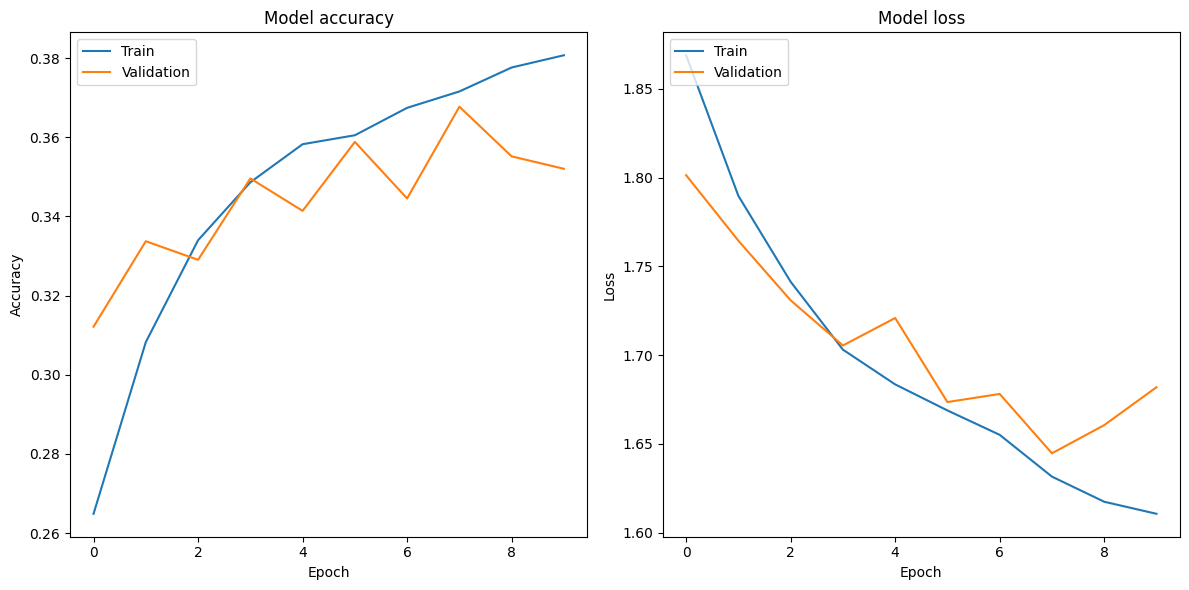

In [39]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# this seems to be be working better but seems like it overfit after the 7th epoch so let's do early stoppage here

36/36 [==============================] - 4s 112ms/step - loss: 1.6645 - accuracy: 0.3565
Test loss: 1.66
Test accuracy: 0.36


In [ ]:


datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)


# defining train and test generators

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # All images will be resized to 48x48
    batch_size=200,
    class_mode='categorical',  
    color_mode='grayscale', # Since we have grayscale images
    subset='training',
    seed = 42)  

validation_generator = datagen_train.flow_from_directory(
    train_dir,  # same directory as training data
    target_size=(48, 48),
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', # set as validation data
    seed = 42)  


datagen_test = ImageDataGenerator(rescale=1./255)  # we don't need validation split for the test data

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(48, 48),  
    batch_size=200,
    class_mode='categorical',
    color_mode='grayscale',
    seed = 42)

model = keras.models.Sequential([keras.layers.Flatten(input_shape = [48, 48]),
keras.layers.Dense(300, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(7, activation = 'softmax' )])


model.compile(loss = 'categorical_crossentropy',
optimizer = 'adam', # The optimizer we are going to use to optimise the model against the loss function is stochastic gradient descent and this will ensure the model converges on an optimum solution
metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 7,
    validation_data = validation_generator 
)

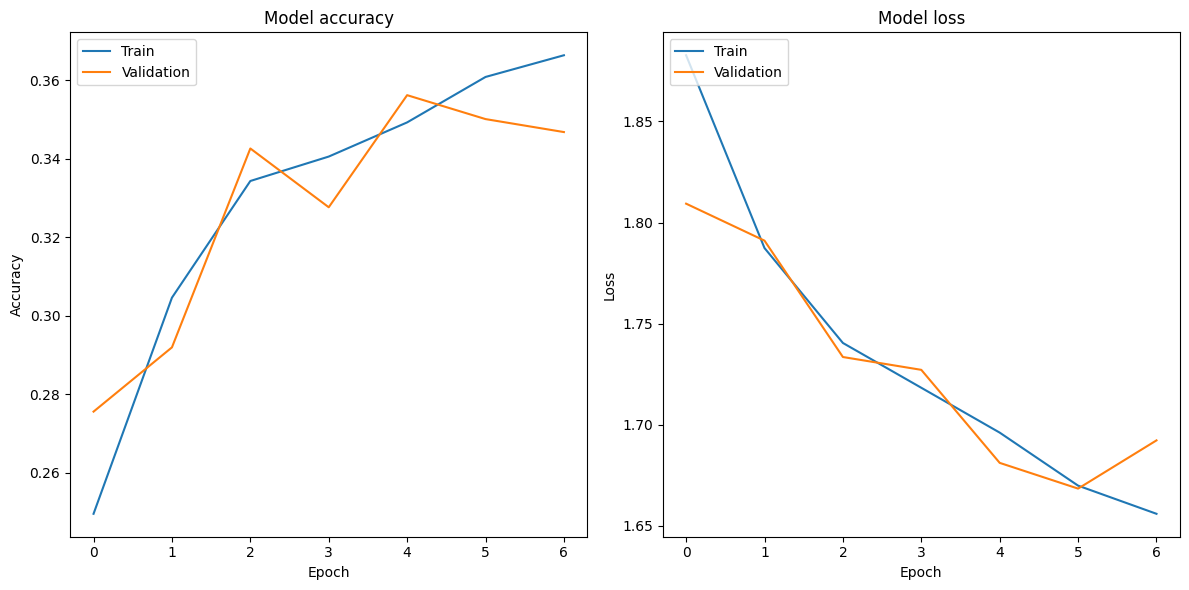

In [42]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')


36/36 [==============================] - 4s 96ms/step - loss: 1.6787 - accuracy: 0.3516
Test loss: 1.68
Test accuracy: 0.35


In [12]:
# last but not least, let's train this model but with balanced weights for the underrepresentad class - disgust

from sklearn.utils import class_weight
import numpy as np


model = keras.models.Sequential([keras.layers.Flatten(input_shape = [48, 48]),
keras.layers.Dense(300, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
keras.layers.Dense(7, activation = 'softmax' )])


model.compile(loss = 'categorical_crossentropy',
optimizer = 'adam', # The optimizer we are going to use to optimise the model against the loss function is stochastic gradient descent and this will ensure the model converges on an optimum solution
metrics = ['accuracy'])


# Compute class weights
class_weights_list = class_weight.compute_sample_weight(class_weight='balanced',
                                                 y=train_generator.classes)
class_weights = dict(enumerate(class_weights_list))

# Now have to assign these class weights while training model
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    class_weight = class_weights)

Epoch 1/10
115/115 [==============================] - 25s 206ms/step - loss: 1.9371 - accuracy: 0.2485 - val_loss: 1.8267 - val_accuracy: 0.2698
Epoch 2/10
115/115 [==============================] - 14s 118ms/step - loss: 1.8311 - accuracy: 0.3089 - val_loss: 1.7678 - val_accuracy: 0.3184
Epoch 3/10
115/115 [==============================] - 13s 112ms/step - loss: 1.7799 - accuracy: 0.3329 - val_loss: 1.7282 - val_accuracy: 0.3254
Epoch 4/10
115/115 [==============================] - 16s 143ms/step - loss: 1.7410 - accuracy: 0.3504 - val_loss: 1.6895 - val_accuracy: 0.3491
Epoch 5/10
115/115 [==============================] - 14s 123ms/step - loss: 1.7219 - accuracy: 0.3576 - val_loss: 1.7136 - val_accuracy: 0.3315
Epoch 6/10
115/115 [==============================] - 14s 119ms/step - loss: 1.7109 - accuracy: 0.3590 - val_loss: 1.6918 - val_accuracy: 0.3395
Epoch 7/10
115/115 [==============================] - 14s 121ms/step - loss: 1.6930 - accuracy: 0.3700 - val_loss: 1.6826 - val_ac

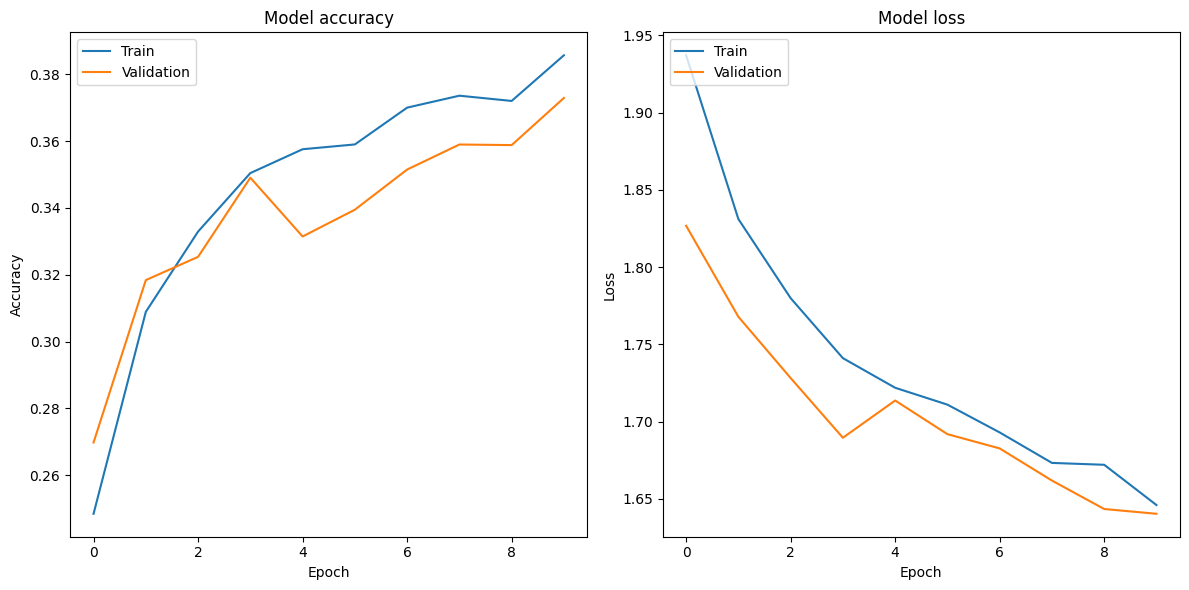

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# this is by far the best result, balancing weight and adding one more layer paid off

36/36 [==============================] - 6s 180ms/step - loss: 1.6277 - accuracy: 0.3827
Test loss: 1.63
Test accuracy: 0.38


In [15]:
# now let's create a proper CNN model 

# we will kick off with a basic one just to see how it does

from tensorflow.keras import layers

model = keras.models.Sequential([
    # First convolutional layer with max pooling
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)), # 32 filters with size of 3x3
    keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional layer with max pooling
    keras.layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters with size of 3x3
    keras.layers.MaxPooling2D((2, 2)),

    # Flattening the output of the convolutional layers
    keras.layers.Flatten(),

    # Adding dense layers
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    
    # Final output layer
    keras.layers.Dense(7, activation='softmax')
])

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [16]:
# Fitting the model
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator 
)

Epoch 1/10
115/115 [==============================] - 29s 241ms/step - loss: 1.7361 - accuracy: 0.2973 - val_loss: 1.6282 - val_accuracy: 0.3585
Epoch 2/10
115/115 [==============================] - 33s 286ms/step - loss: 1.5481 - accuracy: 0.4047 - val_loss: 1.5106 - val_accuracy: 0.4236
Epoch 3/10
115/115 [==============================] - 31s 270ms/step - loss: 1.4384 - accuracy: 0.4495 - val_loss: 1.4338 - val_accuracy: 0.4457
Epoch 4/10
115/115 [==============================] - 32s 276ms/step - loss: 1.3535 - accuracy: 0.4825 - val_loss: 1.3829 - val_accuracy: 0.4621
Epoch 5/10
115/115 [==============================] - 33s 285ms/step - loss: 1.3024 - accuracy: 0.5020 - val_loss: 1.3590 - val_accuracy: 0.4792
Epoch 6/10
115/115 [==============================] - 35s 301ms/step - loss: 1.2499 - accuracy: 0.5257 - val_loss: 1.3656 - val_accuracy: 0.4787
Epoch 7/10
115/115 [==============================] - 36s 312ms/step - loss: 1.2035 - accuracy: 0.5442 - val_loss: 1.3328 - val_ac

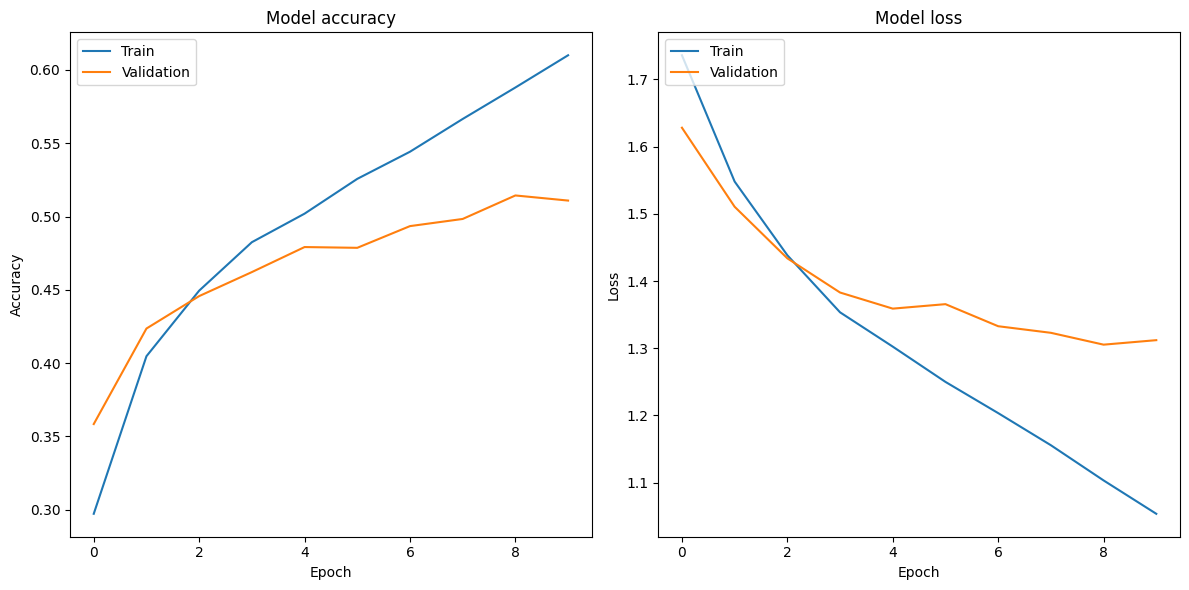

36/36 [==============================] - 6s 152ms/step - loss: 1.2988 - accuracy: 0.5128
Test loss: 1.30
Test accuracy: 0.51


In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# seems like the model started overfitting after 8th epoch

In [20]:
# let's do the same but with balanced weights


model = keras.models.Sequential([
    # First convolutional layer with max pooling
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)), # 32 filters with size of 3x3
    keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional layer with max pooling
    keras.layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters with size of 3x3
    keras.layers.MaxPooling2D((2, 2)),

    # Flattening the output of the convolutional layers
    keras.layers.Flatten(),

    # Adding dense layers
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    
    # Final output layer
    keras.layers.Dense(7, activation='softmax')
])

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    class_weight = class_weights)

Epoch 1/10
115/115 [==============================] - 35s 294ms/step - loss: 1.7764 - accuracy: 0.3012 - val_loss: 1.5842 - val_accuracy: 0.3902
Epoch 2/10
115/115 [==============================] - 39s 341ms/step - loss: 1.5663 - accuracy: 0.4130 - val_loss: 1.4622 - val_accuracy: 0.4377
Epoch 3/10
115/115 [==============================] - 39s 335ms/step - loss: 1.4479 - accuracy: 0.4594 - val_loss: 1.4176 - val_accuracy: 0.4511
Epoch 4/10
115/115 [==============================] - 41s 354ms/step - loss: 1.3592 - accuracy: 0.4923 - val_loss: 1.3527 - val_accuracy: 0.4801
Epoch 5/10
115/115 [==============================] - 45s 389ms/step - loss: 1.2943 - accuracy: 0.5173 - val_loss: 1.3567 - val_accuracy: 0.4862
Epoch 6/10
115/115 [==============================] - 53s 462ms/step - loss: 1.2306 - accuracy: 0.5465 - val_loss: 1.3104 - val_accuracy: 0.5008
Epoch 7/10
115/115 [==============================] - 49s 427ms/step - loss: 1.1677 - accuracy: 0.5706 - val_loss: 1.2934 - val_ac

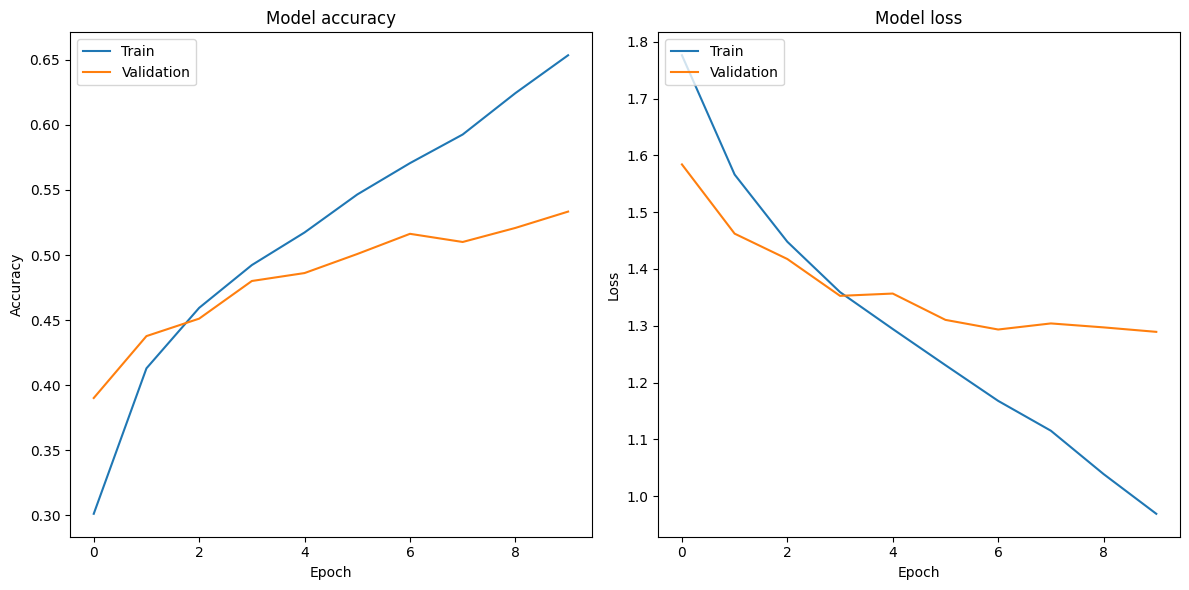

36/36 [==============================] - 10s 286ms/step - loss: 1.2683 - accuracy: 0.5315
Test loss: 1.27
Test accuracy: 0.53


In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')


# the model did better with adjusted weights

In [23]:
# now lets try the same model but with some image augmentation 

datagen_train_augmented = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # reserve some images for validation
    rotation_range=10,    # rotate images by up to 10 degrees
    width_shift_range=0.1,  # shift images horizontally by up to 10% of their width
    height_shift_range=0.1, # shift images vertically by up to 10% of their height
    zoom_range=0.1,       # zoom in on images by up to 10%
    horizontal_flip=True, # flip images horizontally
)

train_generator_augmented = datagen_train_augmented.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # All images will be resized to 48x48
    batch_size=200,
    class_mode='categorical',  
    color_mode='grayscale', # Since we have grayscale images
    subset='training',
    seed = 42)  

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator_augmented,
                    epochs = 10,
                    validation_data = validation_generator,
                    class_weight = class_weights)


Found 22968 images belonging to 7 classes.
Epoch 1/10
115/115 [==============================] - 165s 1s/step - loss: 1.8548 - accuracy: 0.2497 - val_loss: 1.7353 - val_accuracy: 0.2959
Epoch 2/10
115/115 [==============================] - 174s 2s/step - loss: 1.7556 - accuracy: 0.3020 - val_loss: 1.6727 - val_accuracy: 0.3512
Epoch 3/10
115/115 [==============================] - 180s 2s/step - loss: 1.6502 - accuracy: 0.3703 - val_loss: 1.4720 - val_accuracy: 0.4325
Epoch 4/10
115/115 [==============================] - 196s 2s/step - loss: 1.5240 - accuracy: 0.4247 - val_loss: 1.3641 - val_accuracy: 0.4870
Epoch 5/10
115/115 [==============================] - 188s 2s/step - loss: 1.4275 - accuracy: 0.4644 - val_loss: 1.2880 - val_accuracy: 0.5130
Epoch 6/10
115/115 [==============================] - 196s 2s/step - loss: 1.3700 - accuracy: 0.4908 - val_loss: 1.2572 - val_accuracy: 0.5248
Epoch 7/10
115/115 [==============================] - 185s 2s/step - loss: 1.3264 - accuracy: 0.506

In [24]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# augmentation and more complex network seem to have improved the model, but not by a lot


36/36 [==============================] - 14s 369ms/step - loss: 1.1540 - accuracy: 0.5652
Test loss: 1.15
Test accuracy: 0.57


In [26]:
# let's also try a more complex network but with no augmentation


model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    class_weight = class_weights)

Epoch 1/10
115/115 [==============================] - 138s 1s/step - loss: 1.8079 - accuracy: 0.2788 - val_loss: 1.6317 - val_accuracy: 0.3628
Epoch 2/10
115/115 [==============================] - 131s 1s/step - loss: 1.5543 - accuracy: 0.4152 - val_loss: 1.4180 - val_accuracy: 0.4452
Epoch 3/10
115/115 [==============================] - 110s 956ms/step - loss: 1.3913 - accuracy: 0.4794 - val_loss: 1.3487 - val_accuracy: 0.4856
Epoch 4/10
115/115 [==============================] - 129s 1s/step - loss: 1.2893 - accuracy: 0.5246 - val_loss: 1.2879 - val_accuracy: 0.5001
Epoch 5/10
115/115 [==============================] - 140s 1s/step - loss: 1.2043 - accuracy: 0.5549 - val_loss: 1.2227 - val_accuracy: 0.5377
Epoch 6/10
115/115 [==============================] - 143s 1s/step - loss: 1.1201 - accuracy: 0.5883 - val_loss: 1.2222 - val_accuracy: 0.5290
Epoch 7/10
115/115 [==============================] - 128s 1s/step - loss: 1.0476 - accuracy: 0.6147 - val_loss: 1.1857 - val_accuracy: 0.5

In [27]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# so no augmentation model did even worse


36/36 [==============================] - 7s 196ms/step - loss: 1.2272 - accuracy: 0.5667
Test loss: 1.23
Test accuracy: 0.57


In [8]:

# lets try smaller augmentation, smaller batch size, less complex model and dropout 

from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras import regularizers

train_generator_smaller_batch = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # all images will be resized to 48x48
    batch_size=100,
    class_mode='categorical',  
    color_mode='grayscale', # since we have grayscale images
    subset='training',
    seed = 42)  

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001), # Add L2 regularization
                        input_shape=(48, 48, 1)), 
    BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3), # Increase dropout rate
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    BatchNormalization(),
    keras.layers.Dropout(0.3), # Increase dropout rate
    keras.layers.Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator_smaller_batch,
                    epochs = 12,
                    validation_data = validation_generator,
                    class_weight = class_weights)

# it didnt fare well, let's try to reduce complexity and increase dropout as the model clearly overfit


Found 22968 images belonging to 7 classes.
Epoch 1/12
230/230 [==============================] - 123s 522ms/step - loss: 2.8000 - accuracy: 0.3260 - val_loss: 2.7233 - val_accuracy: 0.1761
Epoch 2/12
230/230 [==============================] - 132s 572ms/step - loss: 2.2199 - accuracy: 0.4643 - val_loss: 2.2036 - val_accuracy: 0.4081
Epoch 3/12
230/230 [==============================] - 135s 586ms/step - loss: 1.9105 - accuracy: 0.5276 - val_loss: 1.8681 - val_accuracy: 0.5098
Epoch 4/12
230/230 [==============================] - 135s 586ms/step - loss: 1.7168 - accuracy: 0.5681 - val_loss: 1.7459 - val_accuracy: 0.5229
Epoch 5/12
230/230 [==============================] - 122s 528ms/step - loss: 1.5851 - accuracy: 0.5938 - val_loss: 1.6776 - val_accuracy: 0.5419
Epoch 6/12
230/230 [==============================] - 114s 494ms/step - loss: 1.4929 - accuracy: 0.6260 - val_loss: 1.6868 - val_accuracy: 0.5461
Epoch 7/12
230/230 [==============================] - 114s 496ms/step - loss: 1.4

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001), # Add L2 regularization
                        input_shape=(48, 48, 1)), 
    BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5), # Increase dropout rate
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # Add L2 regularization
    BatchNormalization(),
    keras.layers.Dropout(0.5), # Increase dropout rate
    keras.layers.Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator_smaller_batch,
                    epochs = 12,
                    validation_data = validation_generator,
                    class_weight = class_weights)


# this model sucks, let's try a different approach

Epoch 1/12
230/230 [==============================] - 96s 397ms/step - loss: 2.4932 - accuracy: 0.3044 - val_loss: 4.6332 - val_accuracy: 0.0655
Epoch 2/12
230/230 [==============================] - 87s 380ms/step - loss: 1.9985 - accuracy: 0.4153 - val_loss: 4.2825 - val_accuracy: 0.2247
Epoch 3/12
230/230 [==============================] - 111s 483ms/step - loss: 1.8204 - accuracy: 0.4639 - val_loss: 1.7819 - val_accuracy: 0.4642
Epoch 4/12
230/230 [==============================] - 107s 464ms/step - loss: 1.7243 - accuracy: 0.4946 - val_loss: 1.6895 - val_accuracy: 0.4917
Epoch 5/12
230/230 [==============================] - 84s 367ms/step - loss: 1.6961 - accuracy: 0.5038 - val_loss: 1.6812 - val_accuracy: 0.4884
Epoch 6/12
230/230 [==============================] - 100s 437ms/step - loss: 1.6458 - accuracy: 0.5285 - val_loss: 1.7333 - val_accuracy: 0.4921
Epoch 7/12
230/230 [==============================] - 104s 453ms/step - loss: 1.6359 - accuracy: 0.5401 - val_loss: 1.8074 - va

KeyboardInterrupt: 

In [14]:
# let's experiment more - add dropout to the convolutional layers too, change activation to
from tensorflow.keras import layers
from tensorflow.keras import optimizers

train_generator_smaller_batch = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # All images will be resized to 48x48
    batch_size=140,
    class_mode='categorical',  
    color_mode='grayscale', # Since we have grayscale images
    subset='training',
    seed = 42)  

model = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),
    layers.Conv2D(64, (3, 3), padding='same', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(128, (5, 5), padding='same', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(512, (3, 3), padding='same', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(512, (3, 3), padding='same', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    
    layers.Dense(1024, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(512, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')
])

# Set a smaller learning rate
adam_optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['accuracy'])

history = model.fit(train_generator_smaller_batch,
                    epochs = 30,
                    validation_data = validation_generator,
                    class_weight = class_weights)



Found 22968 images belonging to 7 classes.
Epoch 1/30
165/165 [==============================] - 673s 4s/step - loss: 2.1374 - accuracy: 0.2230 - val_loss: 1.9346 - val_accuracy: 0.2513
Epoch 2/30
165/165 [==============================] - 659s 4s/step - loss: 1.8532 - accuracy: 0.2904 - val_loss: 2.2359 - val_accuracy: 0.2513
Epoch 3/30
165/165 [==============================] - 662s 4s/step - loss: 1.6827 - accuracy: 0.3656 - val_loss: 2.1388 - val_accuracy: 0.2564
Epoch 4/30
165/165 [==============================] - 661s 4s/step - loss: 1.5781 - accuracy: 0.4025 - val_loss: 1.9956 - val_accuracy: 0.2949
Epoch 5/30
165/165 [==============================] - 662s 4s/step - loss: 1.4925 - accuracy: 0.4394 - val_loss: 1.5756 - val_accuracy: 0.3980
Epoch 6/30
165/165 [==============================] - 663s 4s/step - loss: 1.4045 - accuracy: 0.4700 - val_loss: 1.4054 - val_accuracy: 0.4585
Epoch 7/30
165/165 [==============================] - 665s 4s/step - loss: 1.3632 - accuracy: 0.488

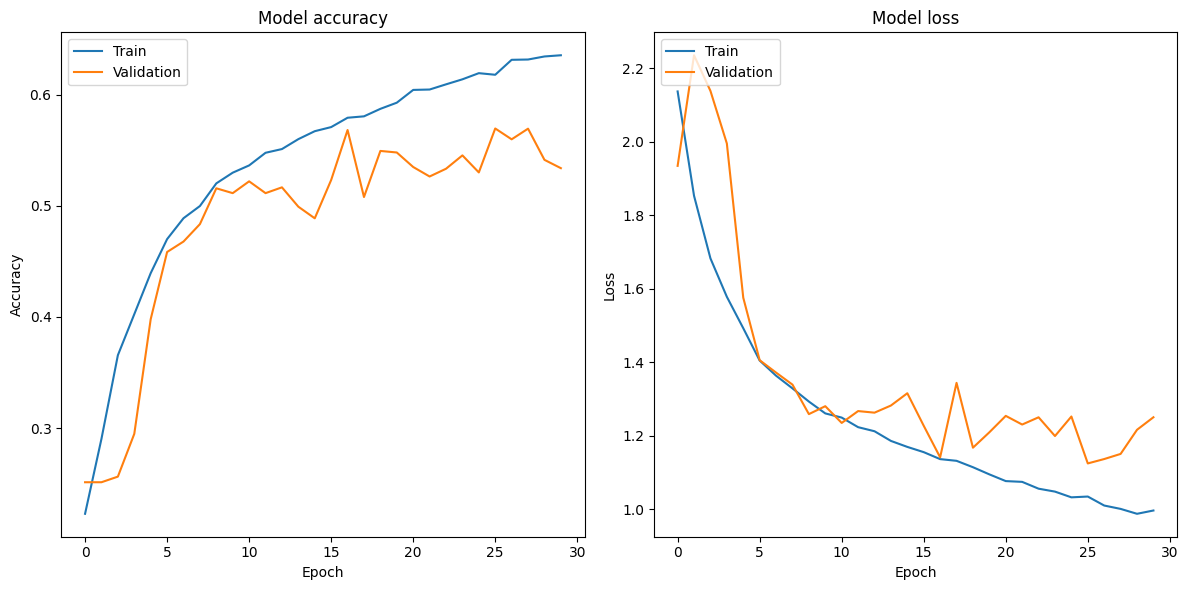

36/36 [==============================] - 38s 1s/step - loss: 1.2239 - accuracy: 0.5412
Test loss: 1.22
Test accuracy: 0.54


In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [30]:
test_loss, test_acc = model.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# it didnt yield better results - it seems like the model could be stopped after thr 16th epoch and would achieve better performance - but still 
# would fall short of 0.6 acc 


36/36 [==============================] - 12s 329ms/step - loss: 1.2723 - accuracy: 0.5566
Test loss: 1.27
Test accuracy: 0.56


In [18]:
# let's create a less complex model with adjusted learning rate

from tensorflow.keras.callbacks import ReduceLROnPlateau

train_generator_smaller_batch_v2 = datagen_train.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # All images will be resized to 48x48
    batch_size=140,
    class_mode='categorical',  
    color_mode='grayscale', # Since we have grayscale images
    subset='training',
    seed = 42)  

# Create a learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)



model = tf.keras.models.Sequential([
    
    layers.Conv2D(32, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(64, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(64, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(128, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(256, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(1024, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')
])

adam_optimizer = optimizers.Adam(learning_rate=0.0008)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs = 12,
                    validation_data = validation_generator,
                    class_weight = class_weights,
                    callbacks=[reduce_lr])

# i think this model shows promise, but it should probably be trained on ~20 epochs to see final results

Epoch 1/12
115/115 [==============================] - 344s 3s/step - loss: 2.1059 - accuracy: 0.2482 - val_loss: 1.9469 - val_accuracy: 0.1730 - lr: 0.0010
Epoch 2/12
115/115 [==============================] - 288s 2s/step - loss: 1.7331 - accuracy: 0.3738 - val_loss: 2.0201 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 3/12
115/115 [==============================] - 1410s 12s/step - loss: 1.5089 - accuracy: 0.4497 - val_loss: 1.9451 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 4/12
115/115 [==============================] - 203s 2s/step - loss: 1.3841 - accuracy: 0.4951 - val_loss: 1.5328 - val_accuracy: 0.4262 - lr: 0.0010
Epoch 5/12
115/115 [==============================] - 242s 2s/step - loss: 1.2941 - accuracy: 0.5276 - val_loss: 1.4466 - val_accuracy: 0.4508 - lr: 0.0010
Epoch 6/12
115/115 [==============================] - 277s 2s/step - loss: 1.2136 - accuracy: 0.5510 - val_loss: 1.2414 - val_accuracy: 0.4996 - lr: 0.0010
Epoch 7/12
115/115 [==============================] - 271s 2s/

In [55]:
# i'm thinking to create another model and use ensembling techniques to get an output based on two models' predictions

model2 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Assuming 7 classes for the emotion recognition task
])


model2.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [57]:
history2 = model2.fit(train_generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    class_weight = class_weights)

Epoch 1/20
115/115 [==============================] - 188s 2s/step - loss: 2.1865 - accuracy: 0.3026 - val_loss: 2.5018 - val_accuracy: 0.1735
Epoch 2/20
115/115 [==============================] - 191s 2s/step - loss: 1.6411 - accuracy: 0.4150 - val_loss: 3.9019 - val_accuracy: 0.1731
Epoch 3/20
115/115 [==============================] - 230s 2s/step - loss: 1.4330 - accuracy: 0.4772 - val_loss: 2.1946 - val_accuracy: 0.2198
Epoch 4/20
115/115 [==============================] - 232s 2s/step - loss: 1.3032 - accuracy: 0.5203 - val_loss: 1.7468 - val_accuracy: 0.3808
Epoch 5/20
115/115 [==============================] - 237s 2s/step - loss: 1.2332 - accuracy: 0.5487 - val_loss: 1.3925 - val_accuracy: 0.4700
Epoch 6/20
115/115 [==============================] - 242s 2s/step - loss: 1.1806 - accuracy: 0.5675 - val_loss: 1.2998 - val_accuracy: 0.5149
Epoch 7/20
115/115 [==============================] - 240s 2s/step - loss: 1.1275 - accuracy: 0.5891 - val_loss: 1.2212 - val_accuracy: 0.5375

In [67]:
history = model.fit(train_generator,
                    epochs = 16,
                    validation_data = validation_generator,
                    class_weight = class_weights,
                    callbacks=[reduce_lr])


Epoch 1/16
115/115 [==============================] - 275s 2s/step - loss: 2.0704 - accuracy: 0.2623 - val_loss: 1.9600 - val_accuracy: 0.1683 - lr: 8.0000e-04
Epoch 2/16
115/115 [==============================] - 252s 2s/step - loss: 1.6782 - accuracy: 0.3916 - val_loss: 2.1336 - val_accuracy: 0.1683 - lr: 8.0000e-04
Epoch 3/16
115/115 [==============================] - 257s 2s/step - loss: 1.4761 - accuracy: 0.4611 - val_loss: 1.8131 - val_accuracy: 0.3332 - lr: 8.0000e-04
Epoch 4/16
115/115 [==============================] - 257s 2s/step - loss: 1.3451 - accuracy: 0.5078 - val_loss: 1.5639 - val_accuracy: 0.3811 - lr: 8.0000e-04
Epoch 5/16
115/115 [==============================] - 257s 2s/step - loss: 1.2518 - accuracy: 0.5374 - val_loss: 1.4483 - val_accuracy: 0.4623 - lr: 8.0000e-04
Epoch 6/16
115/115 [==============================] - 257s 2s/step - loss: 1.1903 - accuracy: 0.5619 - val_loss: 1.3172 - val_accuracy: 0.5145 - lr: 8.0000e-04
Epoch 7/16
115/115 [====================

In [104]:
test_loss, test_acc = model2.evaluate(test_generator)

print(f'Test loss: {test_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

36/36 [==============================] - 17s 460ms/step - loss: 1.2005 - accuracy: 0.6138
Test loss: 1.20
Test accuracy: 0.61


36/36 [==============================] - 12s 326ms/step


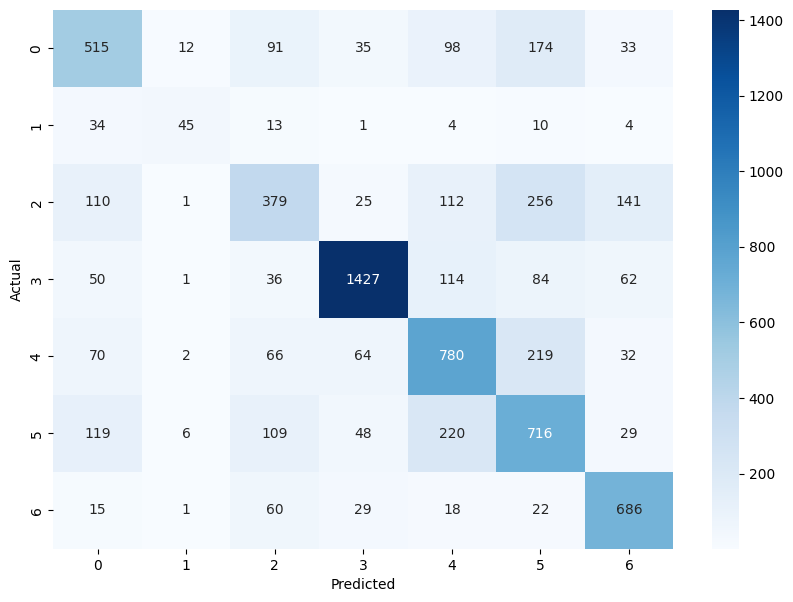

In [72]:
# let's see a confusion matrix for both models

from sklearn.metrics import confusion_matrix
import seaborn as sns


# Make sure generator yields data in the same order every time
test_generator.shuffle = False
test_generator.index_array = None

# Get the true labels from the generator
y_true = test_generator.labels

# Predict the probabilities for each class
y_pred_probs = model.predict(test_generator)

# Get the predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# seaborn to make the confusion matrix more readable
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

36/36 [==============================] - 13s 365ms/step


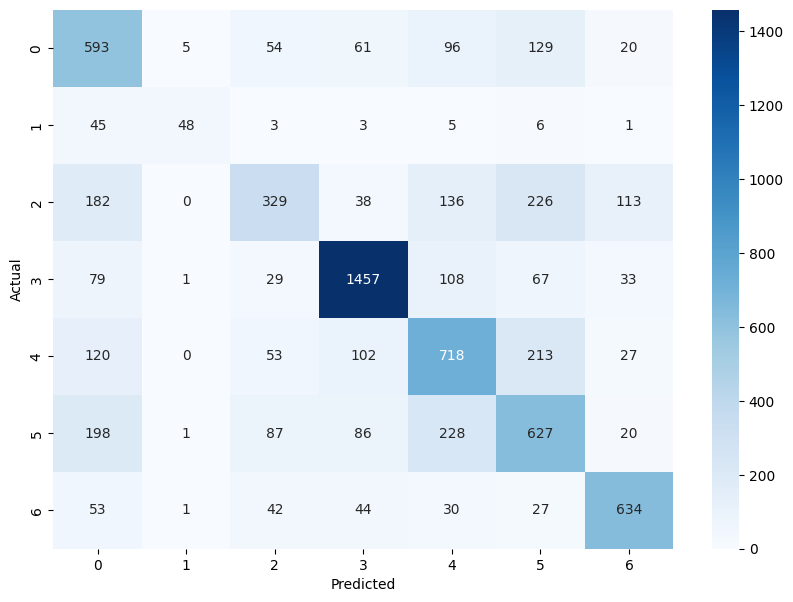

In [73]:
test_generator.shuffle = False
test_generator.index_array = None

# Get the true labels from the generator
y_true = test_generator.labels

# Predict the probabilities for each class
y_pred_probs = model2.predict(test_generator)

# Get the predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# seaborn to make the confusion matrix more readable
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [119]:
# i can see that the 2nd model predictds classes 0 and 3 better than the first model - however, the 1st model predicts all the other ones better
# let's build an ensemble model that will first just take highest value from the output neurons and classify that way
# but also let's build a second ensemble and assign higher weights to classes I think each model does better and see what happens

def ensemble_predict_one(models, data):
    # Make predictions with each model
    predictions = [model.predict(data) for model in models]
    
    # Combine the predictions
    return np.argmax(np.sum(predictions, axis=0), axis=1)  # for classification

# List of models
models = [model_augmented, model2_augmented]

# Make ensemble predictions
ensemble_predictions = ensemble_predict_one(models, test_generator)

36/36 [==============================] - 23s 617ms/step


In [120]:
from sklearn.metrics import accuracy_score, classification_report

test_labels = test_generator.labels

# Calculate accuracy
accuracy = accuracy_score(test_labels, ensemble_predictions)
print(f'Accuracy: {accuracy}')

# Calculate precision, recall, f1-score
report = classification_report(test_labels, ensemble_predictions)
print(report)

Accuracy: 0.6492059069378657
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       958
           1       0.70      0.41      0.52       111
           2       0.54      0.34      0.42      1024
           3       0.87      0.86      0.86      1774
           4       0.56      0.69      0.62      1233
           5       0.53      0.52      0.52      1247
           6       0.73      0.82      0.77       831

    accuracy                           0.65      7178
   macro avg       0.64      0.60      0.61      7178
weighted avg       0.65      0.65      0.64      7178



In [92]:
def ensemble_predict_two(models, data, weights):
    # Make predictions with each model
    predictions = [model.predict(data) for model in models]
    
    # Apply class-specific weights
    for i in range(len(models)):
        for j in range(predictions[0].shape[1]):
            predictions[i][:,j] *= weights[i][j]
    
    # Combine the predictions
    return np.argmax(np.sum(predictions, axis=0), axis=1)  # for classification

# List of models
models = [model, model2]

# Define weights for each model and class
# Model 1 is better at classes 1,2,4,5,6
# Model 2 is better at classes 0,3
weights = [
    [0.3, 0.7, 0.7, 0.3, 0.7, 0.7, 0.7],  # weights for model
    [0.7, 0.3, 0.3, 0.7, 0.3, 0.3, 0.3]   # weights for model2
]

# Make ensemble predictions
ensemble_predictions = ensemble_predict_two(models, test_generator, weights)


36/36 [==============================] - 17s 471ms/step


In [93]:
from sklearn.metrics import accuracy_score, classification_report

test_labels = test_generator.labels

# Calculate accuracy
accuracy = accuracy_score(test_labels, ensemble_predictions)
print(f'Accuracy: {accuracy}')

# Calculate precision, recall, f1-score
report = classification_report(test_labels, ensemble_predictions)
print(report)


# so argmax ensemble does better - interesting

Accuracy: 0.6437726386179995
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       958
           1       0.81      0.38      0.52       111
           2       0.56      0.30      0.39      1024
           3       0.84      0.86      0.85      1774
           4       0.54      0.71      0.61      1233
           5       0.56      0.46      0.50      1247
           6       0.67      0.87      0.76       831

    accuracy                           0.64      7178
   macro avg       0.65      0.60      0.60      7178
weighted avg       0.64      0.64      0.63      7178



In [80]:
# let's train one of the models with augmented data too - see how it does
# also let's add adjusted learning rate 


model2_augmented = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Assuming 7 classes for the emotion recognition task
])

adam_optimizer_augmented = tf.keras.optimizers.Adam(learning_rate=0.001)

model2_augmented.compile(loss='categorical_crossentropy',
               optimizer=adam_optimizer_augmented,
               metrics=['accuracy'])

history2_augmented = model2_augmented.fit(train_generator_augmented,
                    epochs = 18,
                    validation_data = validation_generator,
                    class_weight = class_weights,
                    callbacks = [reduce_lr])

Epoch 1/18
230/230 [==============================] - 285s 1s/step - loss: 2.1146 - accuracy: 0.3010 - val_loss: 3.3592 - val_accuracy: 0.1730 - lr: 0.0010
Epoch 2/18
230/230 [==============================] - 286s 1s/step - loss: 1.6161 - accuracy: 0.4110 - val_loss: 1.5683 - val_accuracy: 0.3656 - lr: 0.0010
Epoch 3/18
230/230 [==============================] - 283s 1s/step - loss: 1.4249 - accuracy: 0.4699 - val_loss: 1.3199 - val_accuracy: 0.4903 - lr: 0.0010
Epoch 4/18
230/230 [==============================] - 291s 1s/step - loss: 1.3275 - accuracy: 0.5060 - val_loss: 1.2441 - val_accuracy: 0.5271 - lr: 0.0010
Epoch 5/18
230/230 [==============================] - 294s 1s/step - loss: 1.2636 - accuracy: 0.5318 - val_loss: 1.2209 - val_accuracy: 0.5421 - lr: 0.0010
Epoch 6/18
230/230 [==============================] - 295s 1s/step - loss: 1.2224 - accuracy: 0.5482 - val_loss: 1.1896 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 7/18
230/230 [==============================] - 291s 1s/st

In [94]:
# let's check out model nr 1 with augmentation too

model_augmented = tf.keras.models.Sequential([
    
    layers.Conv2D(32, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(64, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(64, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(128, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(256, (3, 3), padding='valid', activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(1024, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')
])

adam_optimizer = optimizers.Adam(learning_rate=0.0008)

model_augmented.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['accuracy'])

history_augmented = model_augmented.fit(train_generator_augmented,
                    epochs = 15,
                    validation_data = validation_generator,
                    class_weight = class_weights,
                    callbacks=[reduce_lr])

Epoch 1/15
230/230 [==============================] - 285s 1s/step - loss: 2.0604 - accuracy: 0.2605 - val_loss: 2.0537 - val_accuracy: 0.1730 - lr: 8.0000e-04
Epoch 2/15
230/230 [==============================] - 291s 1s/step - loss: 1.7018 - accuracy: 0.3826 - val_loss: 1.7080 - val_accuracy: 0.3489 - lr: 8.0000e-04
Epoch 3/15
230/230 [==============================] - 306s 1s/step - loss: 1.5049 - accuracy: 0.4528 - val_loss: 1.4335 - val_accuracy: 0.4442 - lr: 8.0000e-04
Epoch 4/15
230/230 [==============================] - 279s 1s/step - loss: 1.3793 - accuracy: 0.4927 - val_loss: 1.3208 - val_accuracy: 0.4912 - lr: 8.0000e-04
Epoch 5/15
230/230 [==============================] - 284s 1s/step - loss: 1.2968 - accuracy: 0.5239 - val_loss: 1.4294 - val_accuracy: 0.4820 - lr: 8.0000e-04
Epoch 6/15
230/230 [==============================] - 276s 1s/step - loss: 1.2336 - accuracy: 0.5430 - val_loss: 1.2602 - val_accuracy: 0.5226 - lr: 8.0000e-04
Epoch 7/15
230/230 [====================

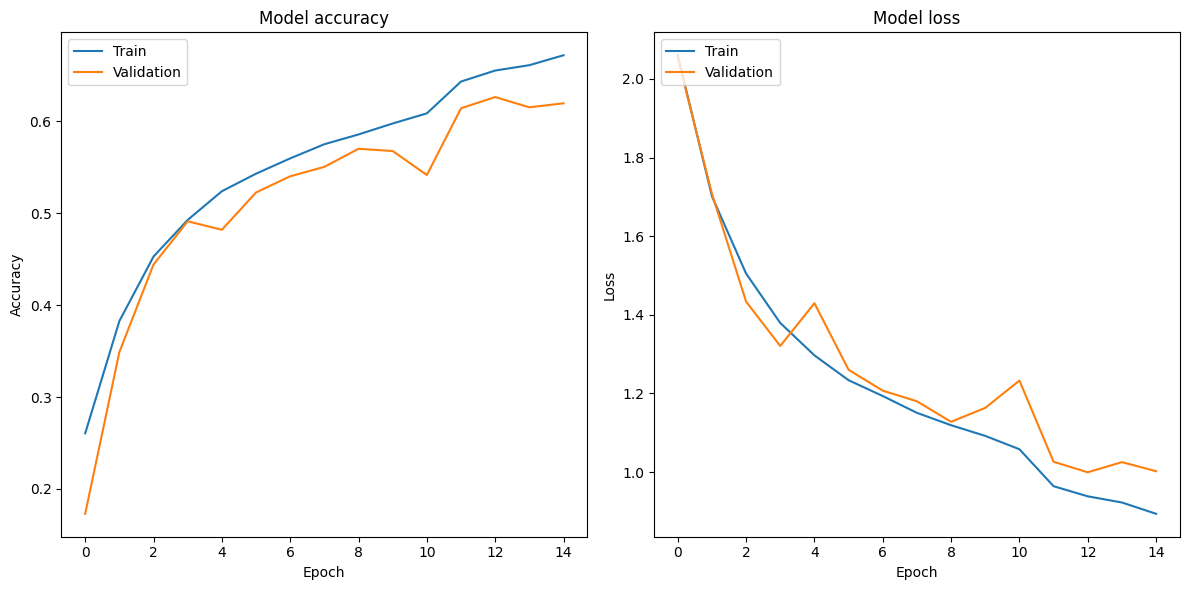

In [105]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

36/36 [==============================] - 26s 715ms/step


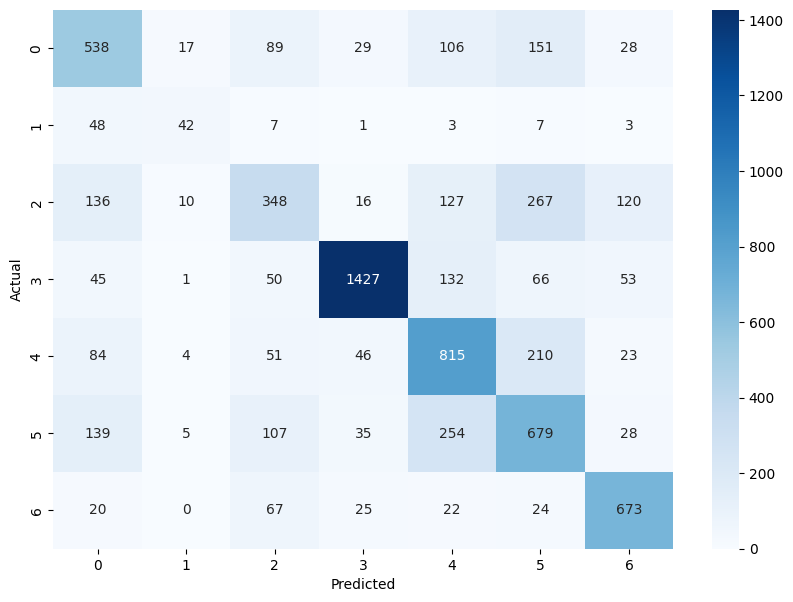

In [107]:
# Make sure generator yields data in the same order every time
test_generator.shuffle = False
test_generator.index_array = None

# Get the true labels from the generator
y_true = test_generator.labels

# Predict the probabilities for each class
y_pred_probs = model_augmented.predict(test_generator)

# Get the predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# seaborn to make the confusion matrix more readable
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()